In [3]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from xgboost import XGBClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from sklearn import metrics
import matplotlib.backends.backend_pdf
%matplotlib inline

In [23]:
def get_data(data_dir):
    fs = [data_dir + f for f in os.listdir(data_dir) if ('signal' in f or 'WZ' in f) and f[0] != '.']
    df = pd.DataFrame()

    for f in fs:
        print f
        new_df = pd.read_csv(f)
        df = pd.concat([df, new_df], ignore_index = True)
        df.index = range(len(df))

    return df

def add_cl_ix(df):
    df['is_sig'] = [1 if 'signal' in val else 0 for val in df.cl.values]
    return df

def train(df, x_cols):
    y_col = 'is_sig'
    model = XGBClassifier(nthread=-1, gamma=0.001, learning_rate=0.1)

    print 'training...'
    model.fit(df[x_cols].values, df[y_col].values)
    #model.fit(df[x_cols].values, df[y_col].values, sample_weight = df.weight.values)
    df['preds'] = model.predict_proba(df[x_cols].values)[:,1]
    print 'done training'

    return df, model

In [44]:
data_dir = '../data/' # Modify this
df = get_data(data_dir)
df = add_cl_ix(df)

../data/bkg_WZqqll.csv
../data/signal_WmWpWm.csv
../data/bkg_WZlvll.csv
../data/signal_WpWpWm.csv


In [47]:
df = df[df.SFOS == 1]
# x_cols = [col for col in df.columns if not col in 
#           ['runNumber', 'lbNumber', 'eventNumber', 'SFOS', 'is_sig', 'weight', 'cl', 'preds', 
#            "Njet",
# "Nbjet",
# "Nel",
# "Nmu",
# "j0_m",
# "j0_pt",
# "j0_eta",
# "j0_phi",
# "l0_m",
# "l0_c",
# "l0_eta",
# "l0_phi",
# "l0_isEl",
# "l1_m",
# "l1_eta",
# "l1_phi",
# "l1_c",
# "l1_isEl",
# "l2_m",
# "l2_eta",
# "12_phi",
# "l2_c",
# "l2_isEl",
# "l0_l1_c",
# "l0_l1_isEl",
# "l1_l2_c",
# "l1_l2_isEl",
# "l2_l0_c",
# "l2_l0_isEl",
#           ]]

x_cols = ['l0_pt', 'l1_pt', 'l2_pt', 'l0_l1_m', 'l0_l1_pt', 
          'l0_l1_eta', 'l0_l1_phi', 'l1_l2_m', 'l1_l2_pt', 'l1_l2_eta', 
          'l1_l2_phi', 'l2_l0_m', 'l2_l0_pt', 'l2_l0_eta', 'l2_l0_phi', 
          'm_3l', 'pt_3l', 'eta_3l', 'phi_3l', 'mt_3l', 'mnew_3l', 'met_pt', 'met_phi']

x_cols_new = ["l0_m","l0_pt","l0_eta","l0_phi", 
              "l1_m","l1_pt","l1_eta","l1_phi", 
              "l2_m","l2_pt","l2_eta","l2_phi",
              "met_pt", "met_phi", "mt_3l", "mnew_3l",
]
print(x_cols, x_cols_new, df.columns)

(['l0_pt', 'l1_pt', 'l2_pt', 'l0_l1_m', 'l0_l1_pt', 'l0_l1_eta', 'l0_l1_phi', 'l1_l2_m', 'l1_l2_pt', 'l1_l2_eta', 'l1_l2_phi', 'l2_l0_m', 'l2_l0_pt', 'l2_l0_eta', 'l2_l0_phi', 'm_3l', 'pt_3l', 'eta_3l', 'phi_3l', 'mt_3l', 'mnew_3l', 'met_pt', 'met_phi'], ['l0_m', 'l0_pt', 'l0_eta', 'l0_phi', 'l1_m', 'l1_pt', 'l1_eta', 'l1_phi', 'l2_m', 'l2_pt', 'l2_eta', 'l2_phi', 'met_pt', 'met_phi', 'mt_3l', 'mnew_3l'], Index([u'runNumber', u'lbNumber', u'eventNumber', u'SFOS', u'Njet', u'Nbjet',
       u'Nel', u'Nmu', u'j0_m', u'j0_pt', u'j0_eta', u'j0_phi', u'l0_m',
       u'l0_pt', u'l0_eta', u'l0_phi', u'l0_c', u'l0_isEl', u'l1_m', u'l1_pt',
       u'l1_eta', u'l1_phi', u'l1_c', u'l1_isEl', u'l2_m', u'l2_pt', u'l2_eta',
       u'l2_phi', u'l2_c', u'l2_isEl', u'l0_l1_m', u'l0_l1_pt', u'l0_l1_eta',
       u'l0_l1_phi', u'l0_l1_c', u'l0_l1_isEl', u'l1_l2_m', u'l1_l2_pt',
       u'l1_l2_eta', u'l1_l2_phi', u'l1_l2_c', u'l1_l2_isEl', u'l2_l0_m',
       u'l2_l0_pt', u'l2_l0_eta', u'l2_l0_phi', u'l2_l0_

In [48]:
df, model = train(df, x_cols_new)

training...
done training


In [52]:
x_bins = np.linspace(0, max(df.preds), 30)
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(3, 1)
ax = plt.subplot(gs[0,:])
plt.title('XGBClassifier Separability')
n_bkg,bins,paint = plt.hist(df[df.is_sig == 0].preds, bins=x_bins, weights=df[df.is_sig == 0].weight, color='r')
plt.yscale('log')
plt.ylabel(r'Weighted Background Counts', size=9)
plt.legend(handles=[mpatches.Patch(color='red', label='Background')])
ax1 = plt.subplot(gs[1,:])
n_sig,bins,paint = plt.hist(df[df.is_sig == 1].preds, bins=x_bins, weights=df[df.is_sig == 1].weight, color='g')
plt.yscale('log')
plt.ylabel(r'Weighted Signal Counts', size=9)
plt.legend(handles=[mpatches.Patch(color='green', label='Signal')])
ax2 = plt.subplot(gs[2,:])
plt.bar((x_bins[:-1] + x_bins[1:]) / 2., n_sig / np.sqrt(n_bkg), width=x_bins[1] - x_bins[0], color='k')
plt.ylabel(r'Significance ($S/\sqrt{B})$', size=9)
plt.xlabel('Probability Event is a Signal')

plt.tight_layout()
plt.savefig('../plots/preds_train.pdf')
plt.close(fig)

fpr, tpr, thresholds = metrics.roc_curve(df.is_sig.values, df.preds.values, pos_label=1)
fig = plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.title('XGBClassifier ROC')
plt.annotate('Area: ' + str(round(metrics.auc(fpr, tpr), 2)), xy=(.8,.2), xycoords='axes fraction')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.savefig('../plots/roc_curve.pdf')
plt.close(fig)
print("Done!")

Done!


100%|██████████| 23/23 [00:14<00:00,  1.57it/s]

DONE!!!


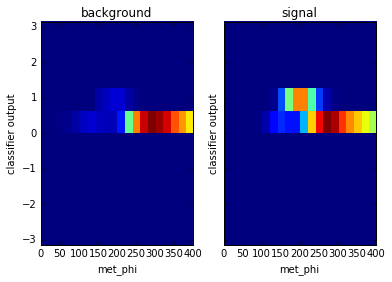

In [51]:
#pred_variable = 'deep_pred'
#pdf = matplotlib.backends.backend_pdf.PdfPages("../plots/2D_plots.pdf")
for var in tqdm(x_cols):
    if "_" not in var:
        continue
    #print(var)
    colors = ['r', 'b']
    title  = {0: 'background', 1: 'signal'}
    
    plt.clf()
    f, axes = plt.subplots(1, 2, sharey=True)
    for sig in [0, 1]:        
        x = df[df['is_sig'] == sig][var]
        y = df[df['is_sig'] == sig]['preds']
        weight = df[df['is_sig'] == sig]['weight']
        
        if ("_m" in var):
            h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 120], [0, 1]])
        elif ("m_3l" in var):
            h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 500], [0, 1]])
        elif ("met_pt" in var):
            h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 400], [0, 1]])
        elif ("met_phi" in var):
            h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 400], [-np.pi, np.pi]])
        elif ("pt" in var):
            h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 200], [0, 1]])
        elif ("mt" in var):
            h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 150], [0, 1]])
        else:
            h = axes[sig].hist2d(x, y, bins=[20, 16], range=[[min(x), max(x)], [0, 1]])
        axes[sig].set_ylabel('classifier output')
        axes[sig].set_xlabel(var)
        axes[sig].set_title(title[sig])
    plt.savefig("../plots/" + var + ".pdf")
    #f.colorbar(h[3]) 
    #plt.show()
    #figures.append(f)
    #pdf.savefig(f)

#pdf.close()
print("DONE!!!")